In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import time
import math
import pandas as pd
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from numpy.fft import fft, ifft, fftshift,ifftshift

## Monte Carlo simulation of the Heston stochastic volatility model

In [3]:
# dS = mu*S*dt + sqrt(V)*S*dW1 <=> dX = (mu-V/2)*dt + sqrt(V)*dW1
# dV = kappa*(Vbar-V)*dt + sigmaV*sqrt(V)*dW2
# dW1*dW2 = rho*dt

# Time grid and Monte Carlo parameters
T = 1 # time horizon
nsteps = 200 # number of time steps
npaths = 20000 # number of paths
dt = T/nsteps # time step
t = np.linspace(0,T,nsteps+1) # observation times

# Market parameters
S0 = 1 # initial stock price
r = 0.02 # risk-free interest rate
q = 0 # dividend rate

# Model parameters
kappa = 3 # mean-reversion rate
Vbar = 0.1 # mean-reversion level
sigmaV = 0.25 # volatility of the volatility (vol of vol)
V0 = 0.08 # initial volatility
rho = -0.8 # correlation of W1 and W2

mu = r-q # GBM drift parameter
Feller_ratio = 2*kappa*Vbar/sigmaV**2 #for monitoring

In [4]:
## Monte Carlo
time_start = time.time()

# Generate correlated standard Gaussian random numbers
N1 = np.random.randn(nsteps,npaths)
N2 = rho*N1+np.sqrt(1-rho**2)*np.random.randn(nsteps,npaths)

# Allocate and initialise the paths for the variance and the log price
v1 = np.full((1,npaths),V0)
v2 = np.zeros((nsteps,npaths))
V = np.concatenate((v1, v2), axis=0)

# Euler-Maruyama for the variance 
a = sigmaV**2/kappa*(np.exp(-kappa*dt)-np.exp(-2*kappa*dt)) # with analytic moments
b = Vbar*sigmaV**2/(2*kappa)*(1-np.exp(-kappa*dt))**2 # with analytic moments
for i in range(nsteps-1): # compute and accumulate the increments
   # V2[i+1,:] = X[i,:] + (mu-0.5*V[i,:])*dt + np.sqrt(V[i,:])*N1[i,:]*np.sqrt(dt)
   # V[i+1,:] = V[i,:] + kappa*(Vbar-V[i,:])*dt + sigmaV*np.sqrt(V[i,:]*dt)*N2[i,:] # plain
   V[i+1,:] = Vbar+(V[i,:]-Vbar)*np.exp(-kappa*dt) + np.sqrt(a*V[i,:]+b)*N2[i,:] # with analytic moments
   V[i+1,:] = np.maximum(V[i+1,:],np.zeros(npaths)) # avoid negative V

# Exact method for the variance
# d = 4*kappa*Vbar/sigmaV**2 #degrees of freedom of the non-central chi square distribution
# k = sigmaV**2*(1-np.exp(-kappa*dt))/(4*kappa)
# for i in range(nsteps): # compute and accumulate the increments
   # lamb = 4*kappa*X[i,:]/(sigmaV**2*(np.exp(kappa*dt)-1))
   # V[i+1,:] = scipy.stats.ncx2.ppf()(np.random.rand(1,npaths),d,lamb)*k  i # 80000 times slower than EM
   # V[i+1,:] = scipy.stats.ncx2.rvs(d,lamb,1,npaths)*k # 40 times slower than EM

# Compute the increments of the arithmetic Brownian motion X = log(S/S0)
dX = (mu-0.5*V[:-1,:])*dt + np.sqrt(V[:-1,:])*N1*np.sqrt(dt)

# Accumulate the increments
x1 = np.zeros((1,npaths))
x2 = np.cumsum(dX, axis=0)
X = np.concatenate((x1, x2), axis=0)

# Transform to geometric Brownian motion
S = S0*np.exp(X) #201 20k

time_end = time.time()
print('time cost',round(time_end-time_start,5),'s')

time cost 0.27722 s


Text(0.5, 1.0, 'Heston Model')

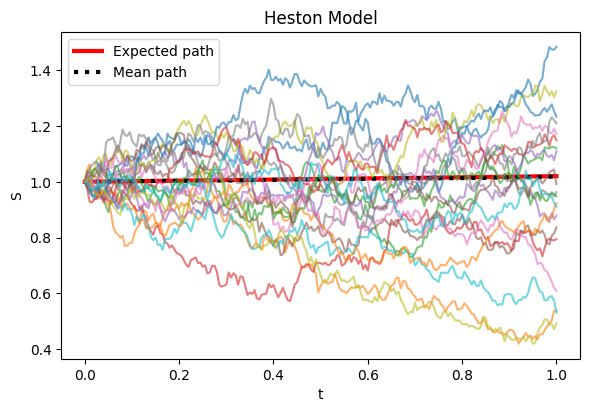

In [5]:
plt.figure(figsize=(6,4))
t = np.linspace(0, T, nsteps + 1)
ES = S0*np.exp(mu*t) # expected path
plt.plot(t, ES, 'r', lw=3)
plt.plot(t, np.mean(S, axis=1), ':k', lw=3)
plt.plot(t, S[:, ::1000], alpha=0.6)
plt.legend(['Expected path', 'Mean path'])
plt.xlabel('t')
plt.ylabel('S')
plt.tight_layout()
plt.title(r'Heston Model')
# plt.savefig('hestonpathsS.png')

In [21]:
# Guidos Paper
def charact_function(kappa, sigma, rho, xi, time, v0, S0, r, Vbar):
    eta = kappa - (sigma * rho * 1j * xi)
    d = np.sqrt(eta**2 + (sigma**2 * (xi**2 + (1j * xi))))
    g1 = (eta + d) / (eta - d)

    A1 = (xi**2 + 1j * xi) * np.sinh(d * t[time] * 0.5)
    A2 = ((d / v0) * np.cosh(d*t[time]*0.5)) + ((eta / v0) * np.sinh(d*t[time]*0.5))
    A=A1 / A2

    B = (d * np.exp(kappa*t[time]*0.5)) / (v0 * A2)
    D = np.log(d/v0) + (0.5 * (kappa - d)*t[time]) - np.log(((d+eta*0.5)/v0) + (((d-eta*0.5)/v0)*np.exp(-d*t[time])))
    F = S0*np.exp((r-q)*t[time]) 

    char_func = np.exp((1j*xi*np.log(F/S0)) - ((kappa * Vbar * rho * t[time] * 1j * xi)/sigma) - A + (((2 * kappa * Vbar)/sigma**2)*D))
    return char_func

/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_1389/3985987491.py:5: RuntimeWarning: divide by zero encountered in divide
  g1 = (eta + d) / (eta - d)
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_1389/3985987491.py:5: RuntimeWarning: invalid value encountered in divide
  g1 = (eta + d) / (eta - d)


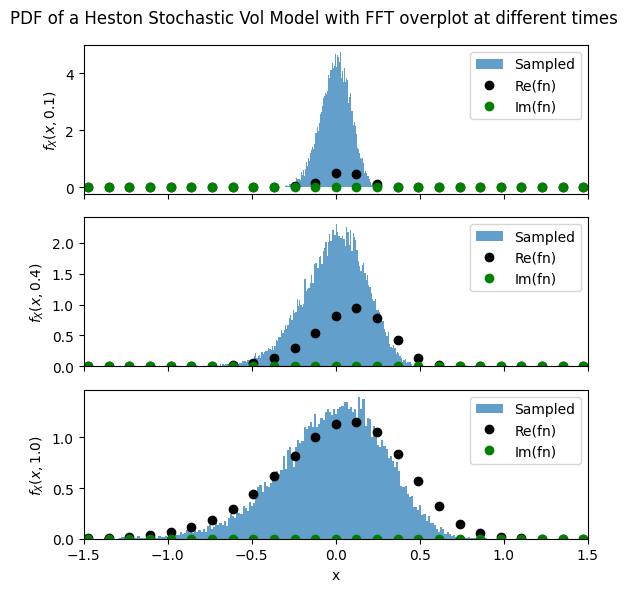

In [26]:
# Model Parameters
S0 = 1 # initial stock price
r = 0.02 # risk-free interest rate
q = 0 # dividend rate

kappa = 3 # mean-reversion rate
Vbar = 0.1 # mean-reversion level
sigma = 0.25 # volatility of the volatility (vol of vol)
v0 = 0.08 # initial volatility
rho = -0.8 # correlation of W1 and W2
mu = r-q # GBM drift parameter

# FT Approx of Pdf using IFFT
t = np.linspace(0, T, nsteps + 1)
N = 512
dx = 0.1
upperx = N * dx
x = dx * np.arange(-N/2, N/2)
dxi = 2 * np.pi / (N * dx)
xi = dxi * np.arange(-N/2, N/2)
# xi2 = np.concatenate([xi-dxi/2, xi[-1]+dxi/2]) # adjusted bins

fig, ax = plt.subplots(3,1, figsize=(6,6), sharex=True)
for i,time in enumerate([20, 80, -2]):

    # Pulsation space: xi
    char_func = charact_function(kappa, sigma, rho, xi, time, v0, S0, r, Vbar)
    f_X = fftshift(fft(ifftshift(char_func))) #/ upperx

    ax[i].hist(X[time,:], density=True, bins=nsteps, alpha=0.7, label='Sampled')
    ax[i].plot(xi,np.real(f_X), 'ko', linewidth=2,  label='Re(fn)')
    ax[i].plot(xi,np.imag(f_X), 'go',  label='Im(fn)')
    
    ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
    ax[i].set_xlim(-1.5,1.5)
    ax[i].legend(loc=0)

plt.suptitle('PDF of a Heston Stochastic Vol Model with FFT overplot at different times')
plt.xlabel('x')
plt.tight_layout()

Text(0.5, 1.0, 'Comparing the theoretical mean of Brownian Bridge with the one estimated via MC')

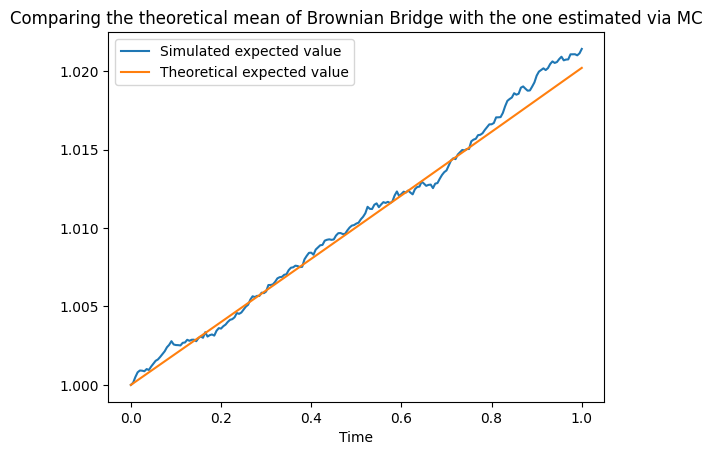

In [ ]:
# Estimate mean of X(t) from the simulations and compare to the true one
plt.figure()
t = np.linspace(0, T, nsteps+1)
plt.plot(t, np.mean(S, axis=1), label='Simulated expected value')
plt.plot(t, ES, label='Theoretical expected value')
plt.xlabel('Time')
plt.legend(loc=0)
plt.title('Comparing the theoretical mean of Brownian Bridge with the one estimated via MC') 

<>:10: SyntaxWarning: invalid escape sequence '\ '
<>:10: SyntaxWarning: invalid escape sequence '\ '
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_95574/3049928647.py:10: SyntaxWarning: invalid escape sequence '\ '
  plt.ylabel('$\ Var(X) = E[(X^2)-(E(X)^2)]$')


Text(0.5, 1.0, 'Heston Stochastic Volatility: Mean Square Deviation')

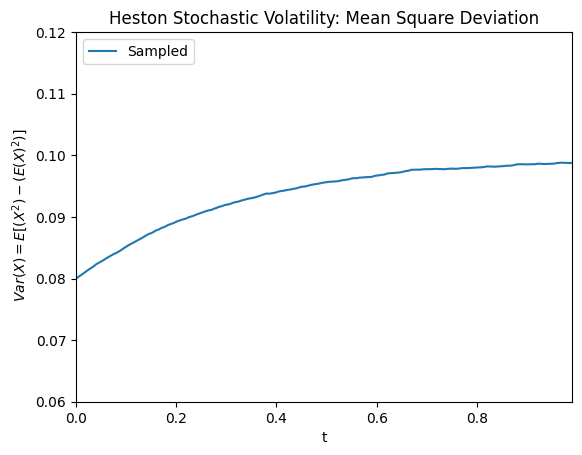

In [ ]:
# Variance = mean square deviation = mean square displacement of random part
plt.figure()
s=0
# plt.plot(t, (sigma**2)*(t/T)*(T-t), label=r'Theory: $(\sigma^2)*(t/T)*(T-t)$')
plt.plot(t, np.mean(V,axis=1), label='Sampled')
plt.legend(loc='upper left')
plt.xlim(0,0.99)
plt.ylim(0.06,0.12)
plt.xlabel('t')
plt.ylabel('$\ Var(X) = E[(X^2)-(E(X)^2)]$')
plt.title('Heston Stochastic Volatility: Mean Square Deviation')

Text(0.5, 1.0, 'Heston: autocovariance')

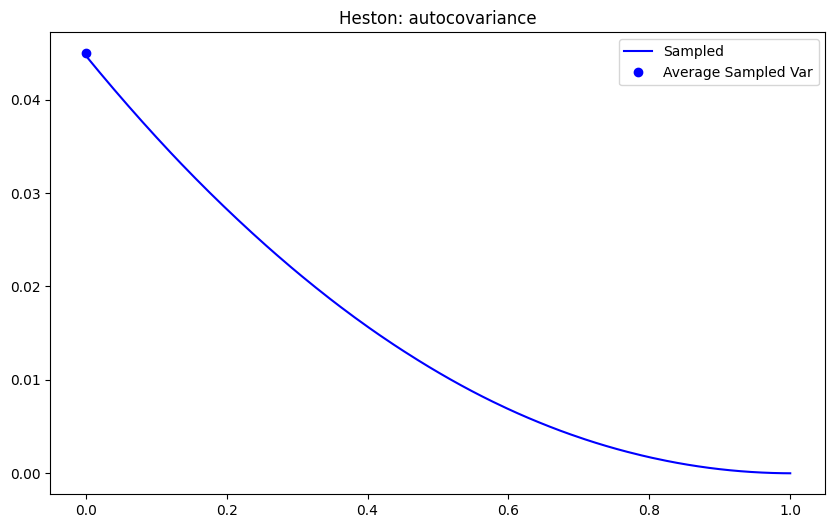

In [ ]:
# Autocovariance
from scipy.signal import correlate

# Initialize the autocovariance array
C = np.zeros((npaths, 2 * nsteps+1))

# Calculate the autocovariance for each path
for i in range(npaths):
    deviation = S[:, i] - ES
    # Compute autocorrelation and normalize by the number of steps
    C[i, :] = correlate(deviation, deviation, mode='full') / nsteps

# Average over all paths
C = np.mean(C, axis=0)

plt.figure(figsize=(10, 6))
t = np.linspace(0, T, nsteps)

# Plot theoretical autocovariance - (t∧z−s)(T−t∨z))/(T-s)
# plt.plot(t, ____, 'r', label='Theory')

# Plot sampled autocovariance
# plt.plot(0, sigma**2 / (2 * alpha), 'ro', label ='Theory Variance for Infinite t')  # Var for infinite t (sigma^2 / (2 * alpha))
plt.plot(t, C[-nsteps:], 'b', label='Sampled')
plt.plot(0, np.mean(np.var(S, axis=1)), 'bo', label='Average Sampled Var') # average sampled variance
plt.legend(loc=0)
plt.title('Heston: autocovariance')